![Phishing Logo](https://dynasis.com/wp-content/uploads/2019/03/phishing2.jpg)



# Phishing Detector
---
Author: Peter Vuong

# Business Understanding
--- 
Phishing is a type of cyber-attack that is engineered to steal user data that often includes login credentials, bank accounts, credit card numbers, and much more personal and sensitive information. Phishing attacks are particularly predatory against older people who are often not as familiar with technology. The goal of this project is to create a model that would accurately identify phishing websites as well as educate the general public about common features that are often associated with phishing websites.

# Overview
---
This project aims to build a classification model to accurately identify what a phishing website is. The dataset used has came from Mendeley has roughly 12,000 rows of data. This data was collected from 2020. <br>
Logistic Regression modeling is used to classify a website as legitimate(0) or phishing(1) based on the features present in the dataset. 

# Technical Overview
---
The data utilized in this project is from [Mendeley Data](https://data.mendeley.com/datasets/c2gw7fy2j4/3). This data initially contained 87 features that were extracted from websites utilizing Python scripts. <br>
Some of these features include:
- `google_index` - whether or not a website has been properly added to Google's index or not
- `phish_hints` - common features that are present in phishing websites such as incorrect spelling, urgent call to action, etc.
- `nb_www` - number of times the string 'www' appears in the URL

These features and many others in the dataset are common properties that are present in most, if not all URLs. <br>
Initial preparation of the data included removing features that had no values (0) in them followed by a stepwise selection in order to identify significant features. After the stepwise selection, an initial baseline and LogisticRegression model was conducted with the leftover 42 features. To further reduce the complexity of the model, an ExtraTreesClassifier was conducted on the data in order to identify the top 10 features that are important to the dataset. Once these features were identified, a final model with optimized hyperparameters from GridSearchCV was conducted on the data that produced an accuracy score of 92% and a recall score of 93%.

# Data Understanding
---
The data from this project comes from [Mendeley Data](https://data.mendeley.com/datasets/c2gw7fy2j4/3). This data initially had 87 features in the data. The target variable in this project is the `status` feature where `0 = legitimate` and `1 = phishing`. After preliminary EDA, 5 features were dropped from the initial dataset since they had zero entries in their respective feature columns. After this, the Pearson correlation coefficient was identified for each feature; however, the correlation coefficients were not as informative as expected. A stepwise selection was utilized instead to filter out features that weren't significant to the dataset. Features that were deemed non-signficant had a P-value > 0.05. After the step-wise selection, the number of features was reduced from 82 to 42 features. After a preliminary model was conducted on these 42 features, an ExtraTreeClassifier was utilized to identify the top 10 non-parametric features in the dataset. These features are isolated from the overall dataset to signify that these are features that are commonly associated with a phishing website.

In [305]:
# Importing necessary libraries to be used throughout the project
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Loading of Data and Initial EDA

In [259]:
# Loading in dataset as dataframe
df = pd.read_csv('data/dataset_B_05_2020.csv')
df

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,phishing
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,legitimate
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,legitimate


In [260]:
# Preliminary information from .info() function
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

Here we see that the data thankfully has no missing values, so no sampling techniques are required for this dataset.

In [265]:
# Calling describe just to get a general breakdown of the dataset.
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000


In [261]:
# Setting paramters for matplotlib graphs to default to this size
plt.rcParams['figure.figsize'] = (20,10)

The target variable in this project is going to be the `status` column, which has string values of `phishing` and `legitimate`.

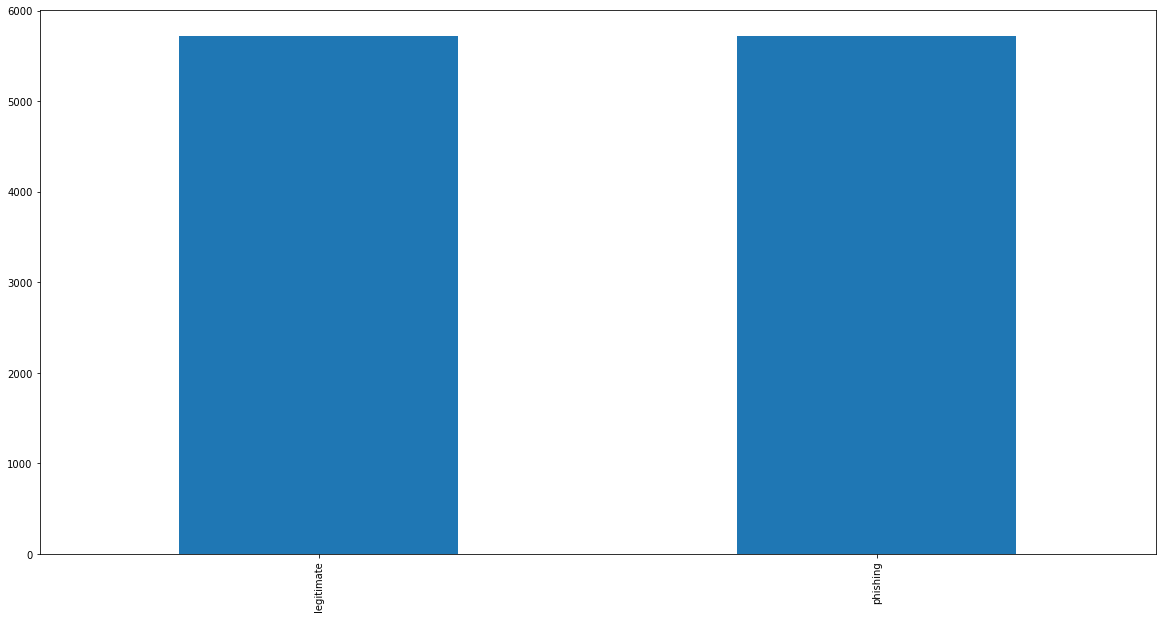

In [262]:
# Visualizing initial split of our target variable. There is an even split between the phishing and legitimate values,
# so there is no class imbalance.
df['status'].value_counts().plot(kind='bar');

Here I count the values in each feature of the dataset just to get a better understanding of what outliers or common values there may be. The code block is commented out since the output is exceedingly large.

In [263]:
# Created simple for loop to print out values in each column just to visualize and investigate
# Commented this out since the output is very lengthy
# for c in df.columns:
#    print("---- %s ---" % c)
#3    print(df[c].value_counts())

Here I check to see what some URLs may look like based on their features identified in the value counts.

In [306]:
# Exploring the data based on the value counts above just to visualize what some URLs would look like
df.loc[df['google_index'] == 0]

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
6,http://www.mutuo.it,19,12,0,2,0,0,0,0,0,...,0,1,0,170,7529,0,0,0,1,legitimate
8,http://vamoaestudiarmedicina.blogspot.com/,42,34,0,2,0,0,0,0,0,...,1,1,0,371,7298,0,0,0,5,legitimate
9,https://parade.com/425836/joshwigler/the-amazi...,104,10,0,1,10,0,0,0,0,...,1,0,0,128,9368,6774,0,0,5,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11417,http://www.assignmentpoint.com/business/market...,69,23,0,3,1,0,0,0,0,...,1,1,0,150,3138,33758,0,0,4,legitimate
11420,https://adnanboz.wordpress.com/2012/01/06/how-...,116,22,0,2,12,0,0,0,0,...,1,0,0,585,7449,0,0,0,8,legitimate
11422,http://sheetdownload.com/,25,17,0,1,0,0,0,0,0,...,0,0,0,144,2778,788648,0,0,2,legitimate
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate


After completing preliminary EDA, the columns stored in the `columns_to_drop` list are dropped from the dataset because thy have blank entries and are not useful for the scope of my project.

In [266]:
# Dropped these columns because all the values present in these columns were 0
columns_to_drop = ['nb_or', 'nb_space', 'submit_email','ratio_intRedirection','ratio_intErrors', 'ratio_nullHyperlinks', 'sfh' ]
df_dropped = df.copy().drop(columns = columns_to_drop)

After dropping these data values from the dataframe, I change the object values of the target feature `status` to a binary classification where `legitimate = 0` and `phishing = 1`.

In [267]:
# Since this is a classification project, I am changing the values in the status columns from legitimate: 0
# and the values of phishing: 1
df_label = pd.DataFrame(df_dropped['status'].copy())
phish = df_label.replace({"status": {"legitimate" : 0, 
                                "phishing" : 1}})
df_dropped['status'] = phish

In [308]:
# Checking to see that the features were dropped correctly 
df_dropped

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,3,...,1,0,0,14,4004,5828815,0,1,0,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,0
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,1,...,1,0,0,211,6728,0,0,1,0,1
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,1,...,0,0,0,2809,8515,8,0,1,10,0
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,0


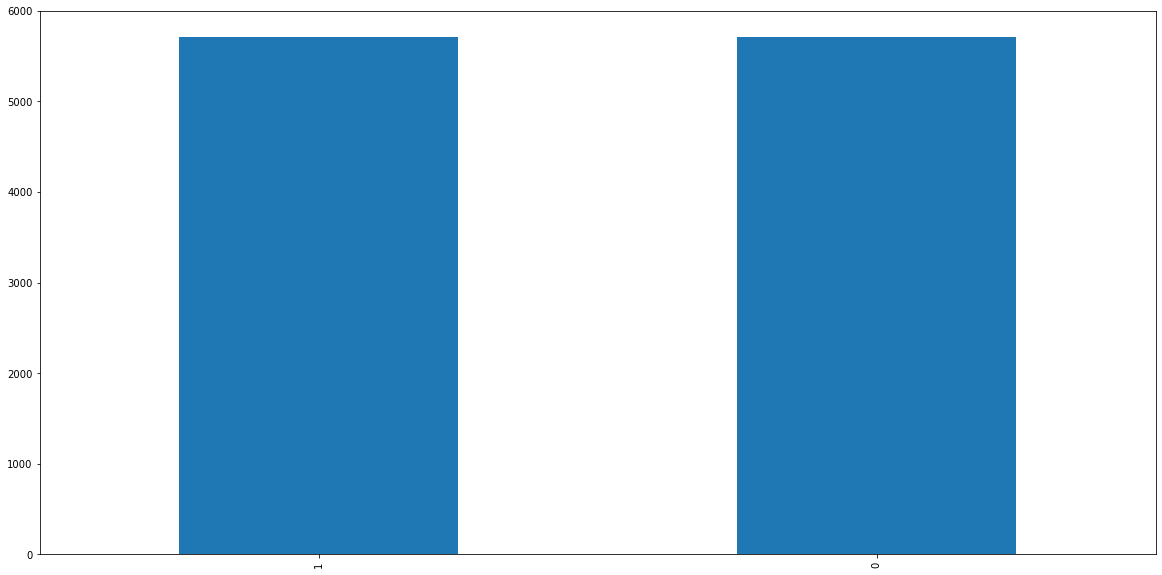

In [310]:
# Checking to see that the values were changed correctly
df_dropped['status'].value_counts().plot(kind='bar');

In [278]:
# Created a copy of dataframe where URLs are just replaced with their corresponding index
# Keeping the URLs in separate dataframe for reference
dropped_url_df = df_dropped.copy()
dropped_url_df['url'] = dropped_url_df.index

## Some functions to be used throughout project

Below I define some functions that will be utilized throughout my project

In [311]:
# Function that plots correlation heatmap in batches since there are so many initial features
def partial_heatmap(data, start, stop):
    y = data['status']
    df = data.iloc[:, start:stop]
    sns.heatmap(df.corr(), annot=True, fmt='.2f')
    plt.show()
    
# Function that prints out training/test scores for each metric of training and test data and corresponding confusion matrix
def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred) * 100), 2)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    roc_cirve = plot_roc_curve(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Recall: {rscore_train}%
    ------------------------------
    Test Accuracy: {ascore_test}%
    Test Recall: {rscore_test}%
    """)

def get_stats(x_columns):
    x = df[x_columns]
    results = sm.OLS(y, X).fit()
    print(results.summary())

After initial EDA and the functions were defined, I start exploring the correlation between the variables. I initially start with a correlation heatmap as that is the simplest correlation metric to identify. The heatmaps are created in such a way that it shows the features of specific indices so that it produces a visualization that is easily interpreted. 

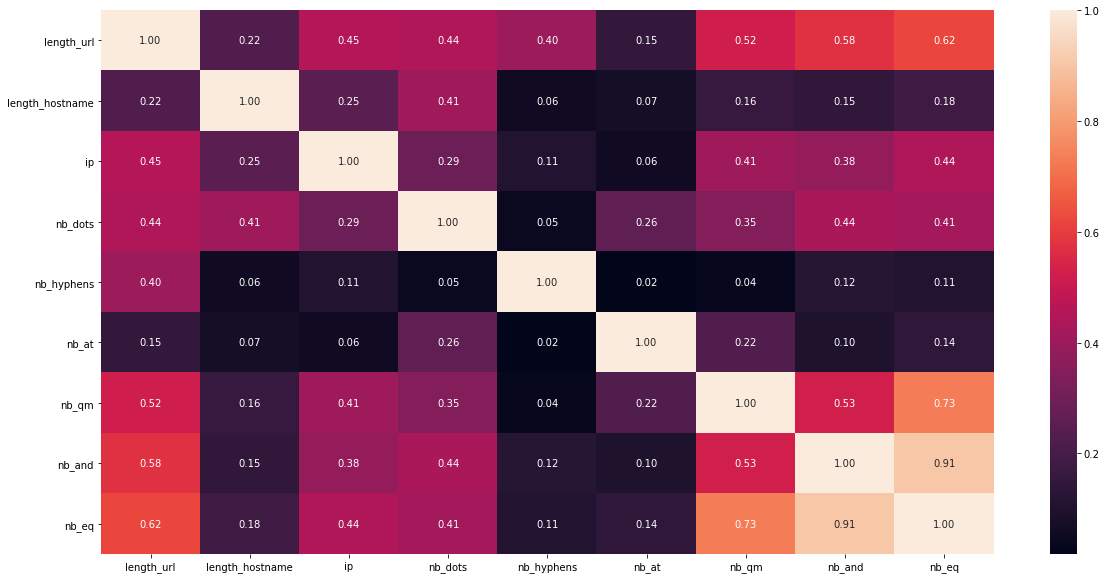

In [271]:
partial_heatmap(df_dropped, 0, 10)


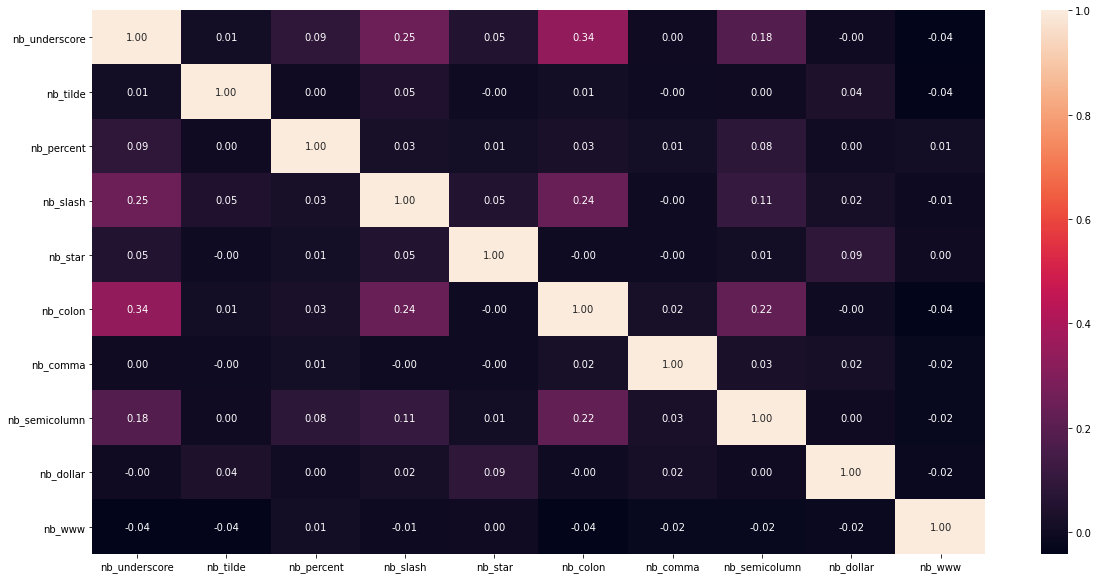

In [272]:
partial_heatmap(df_dropped, 10, 20)


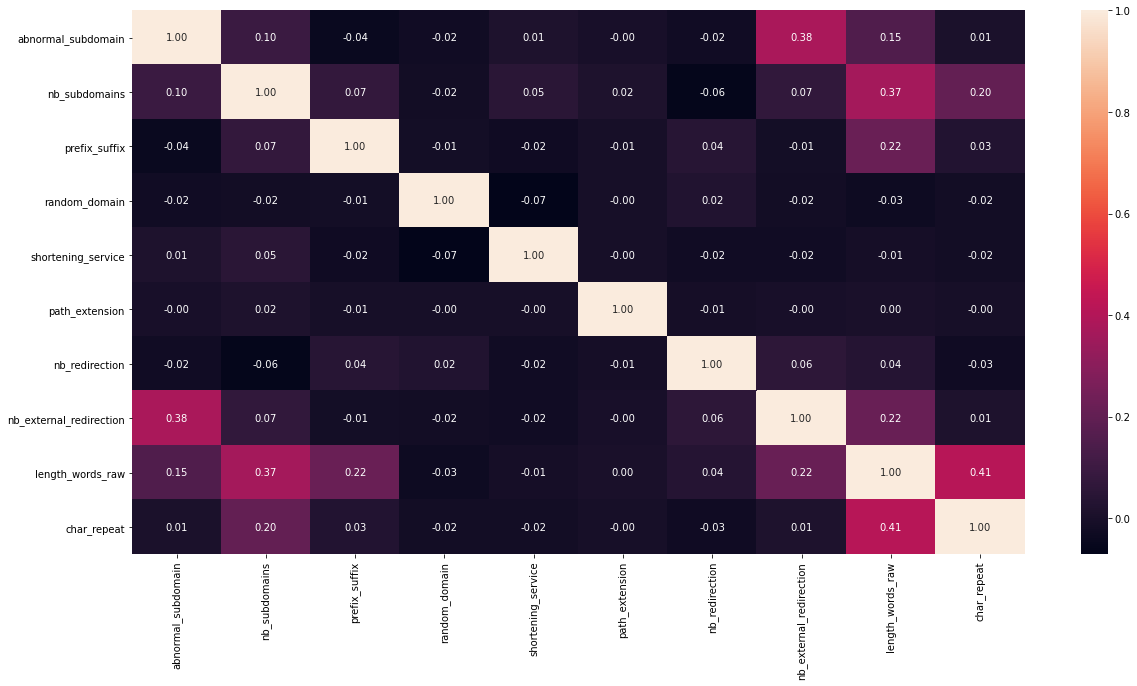

In [273]:
partial_heatmap(df_dropped, 30, 40)


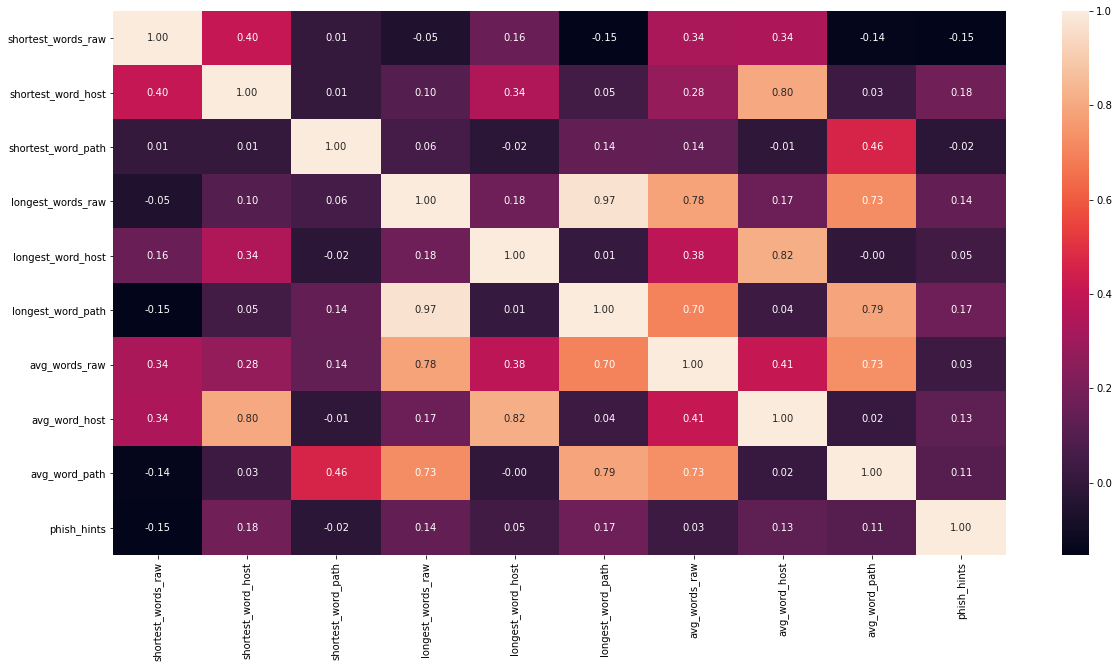

In [274]:
partial_heatmap(df_dropped, 40, 50)


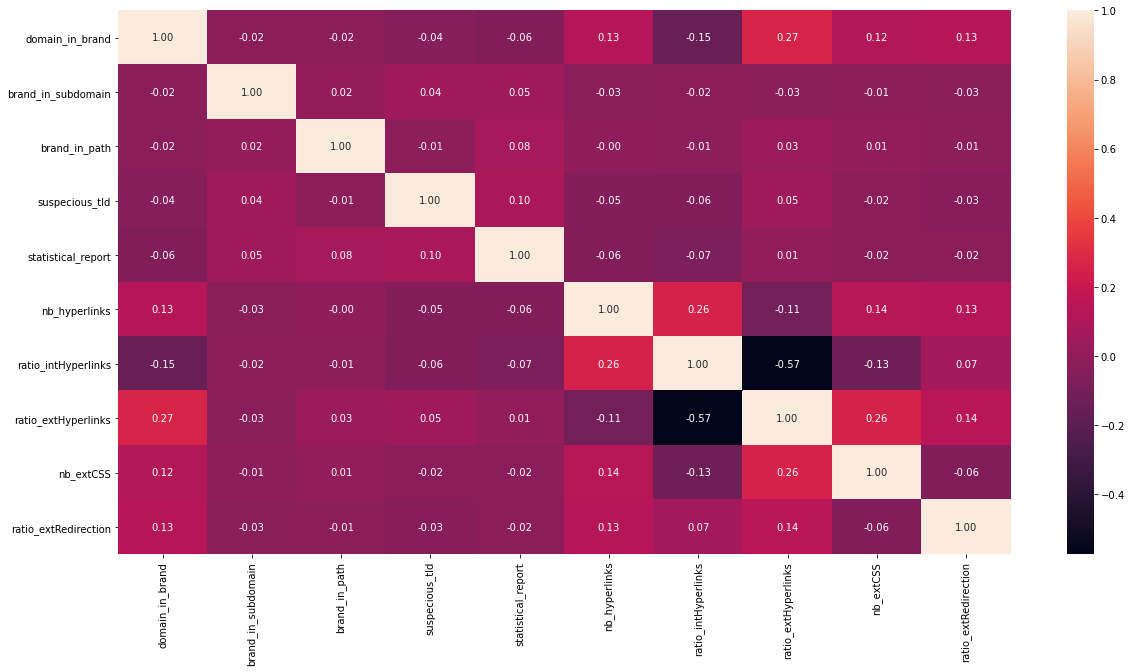

In [275]:
partial_heatmap(df_dropped, 50, 60)


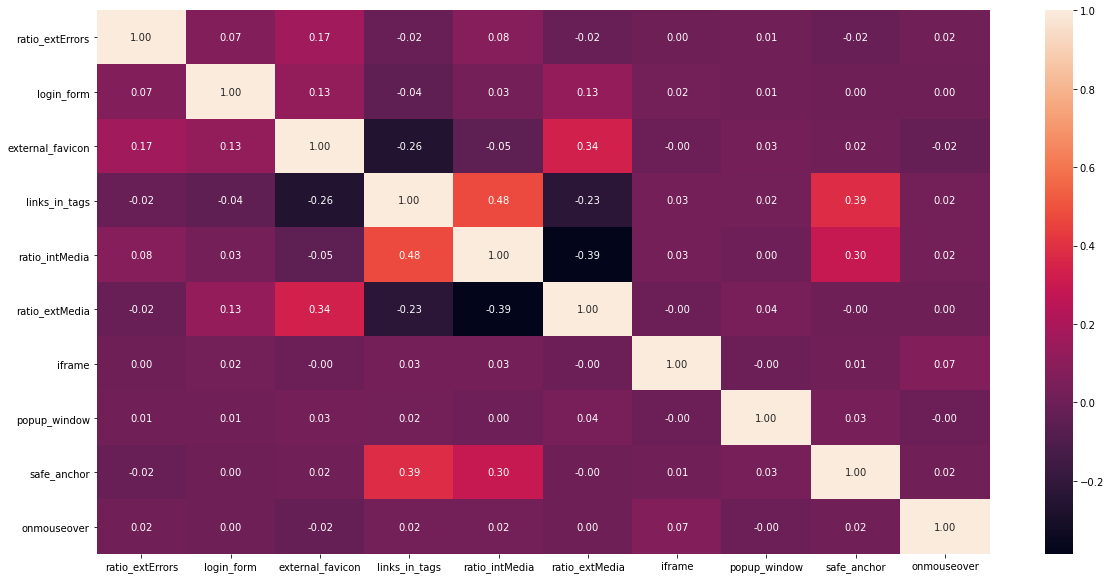

In [276]:
partial_heatmap(df_dropped, 60, 70)


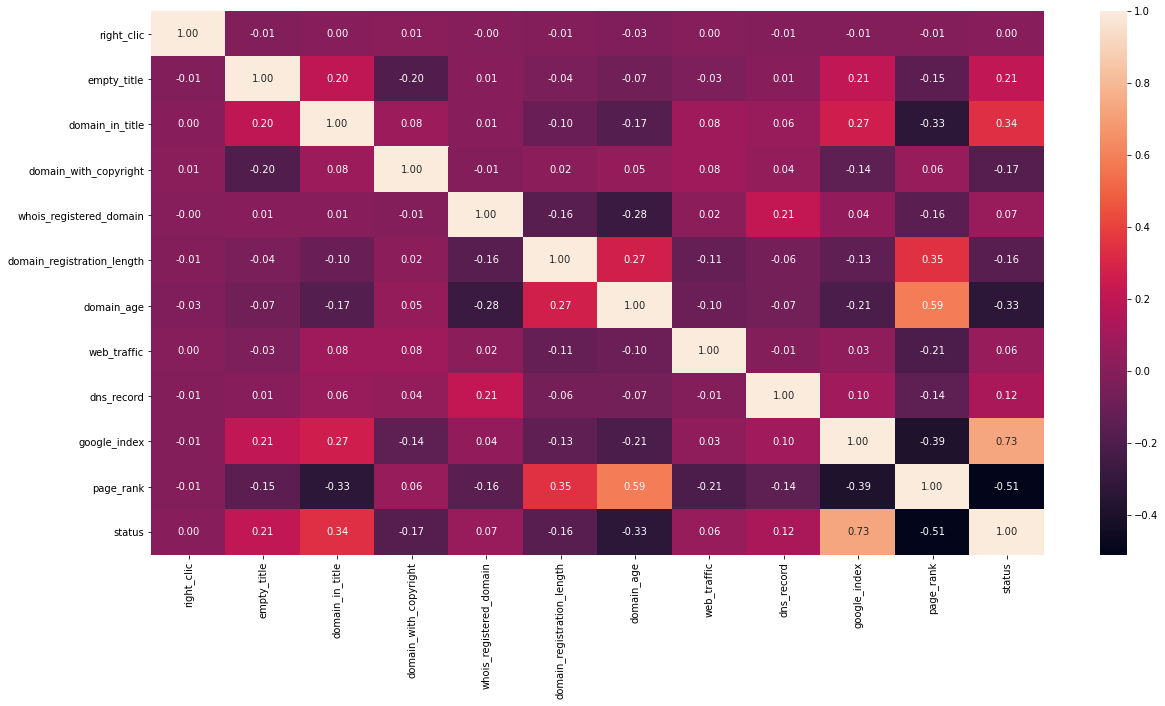

In [277]:
partial_heatmap(df_dropped, 70, 82)


After investigating the Pearson coefficient between the variables in our dataset, we recognize that some multicollinearity exists between some variables; however, I recognize that the Pearson coefficient is not as strong of a correlation comparison metric as Variance Inflation Factor.

## Stepwise selection for feature importance

After exploring the collinearity of the features, I wanted to move forward with stepwise selection to identify features that would be significant to my data. <br>
Initially, the dataset had 87 features. I dropped a couple of features in my preliminary data exploration since those columns had 0 values in them. This dropped my number of features down to 82; however, I still wanted to minimize the number of features in the dataset so I could focus on what features would be most important in identifiying a phishing website. <br>
 

In [279]:
# Creating a list of the column names
x_columns = df.columns.tolist()
X = dropped_url_df
y = dropped_url_df['status']

In [280]:
# Run a summary stats to see what the p-values are. Drop features that have p-value > 0.05
get_stats(x_columns)

                                 OLS Regression Results                                
Dep. Variable:                 status   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.839e+21
Date:                Fri, 15 Apr 2022   Prob (F-statistic):                        0.00
Time:                        14:58:14   Log-Likelihood:                      2.4492e+05
No. Observations:               11430   AIC:                                 -4.897e+05
Df Residuals:                   11348   BIC:                                 -4.891e+05
Df Model:                          82                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [281]:
# Based on the statistical report, these features had a p-valuen of > 0.05 thus they will be dropped from the dataset
features_to_drop = ['url', 'length_url', 'nb_hyphens', 'nb_and', 'nb_underscore', 'nb_tilde', 'nb_star', 'nb_comma', 'nb_semicolumn', 'nb_dollar', \
'nb_com', 'nb_dslash', 'http_in_path', 'punycode', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', \
'prefix_suffix', 'random_domain', 'path_extension', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', \
'longest_words_raw', 'longest_word_host', 'avg_words_raw', 'avg_word_host', 'brand_in_subdomain', 'brand_in_path', \
'statistical_report', 'nb_extCSS', 'ratio_extErrors', 'login_form', 'links_in_tags', 'iframe', 'popup_window', \
'onmouseover', 'right_clic', 'web_traffic']

stepwisedf = dropped_url_df.drop(columns = features_to_drop) 

In [282]:
# Printing out .info of the new stepwisedf to see how many features remain
stepwisedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   length_hostname             11430 non-null  int64  
 1   ip                          11430 non-null  int64  
 2   nb_dots                     11430 non-null  int64  
 3   nb_at                       11430 non-null  int64  
 4   nb_qm                       11430 non-null  int64  
 5   nb_eq                       11430 non-null  int64  
 6   nb_percent                  11430 non-null  int64  
 7   nb_slash                    11430 non-null  int64  
 8   nb_colon                    11430 non-null  int64  
 9   nb_www                      11430 non-null  int64  
 10  https_token                 11430 non-null  int64  
 11  ratio_digits_url            11430 non-null  float64
 12  ratio_digits_host           11430 non-null  float64
 13  port                        114

The amount of features decreased from 82 to 42 following the stepwise selection. This reduction is very beneficial to reducing the complexity of the model. Next, I would like to focus on the coefficients of the initial Logistic Regression model as well as utilize an ExtraTreesClassifier to identify the top 10 features of my dataset in order to reduce even more model complexity. 

In [283]:
# Creating X and y variables for initial train/test split.
# This train/test split is based on the
stepwise_X = stepwisedf.drop(columns = 'status')
stepwise_y = stepwisedf['status']
X_train, X_test, y_train, y_test = train_test_split(stepwise_X, stepwise_y, random_state = 42)

Based on an alpha value of significance of 0.05, we were able to drop our features from 82 features to 42 features. Based on the heat maps generated above of the Pearson coefficients, I want to investigate the multi-collinearity that is present in my dataset. <br>
Although we investigated the collinearity with the heatmaps, I will be looking into the Variance Inflation Factor(VIF) next since the VIF investigates the variance between our features. I am choosing to utilize VIF over the Pearson correlation heatmaps since VIF focuses on the correlation of one feature to the other features vs the Pearson correlation of one feature to another feature. My intent with using VIF is to address the variables that have high correlation with one another and reduce the overall complexity of my model. 

## VIF Exploration

In [284]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif["features"] = X_train.columns
vif.sort_values(by="VIF",ascending=True, inplace=True)
vif.head(50)

,VIF,features
24,1.077118,suspecious_tld
13,1.107718,port
3,1.180498,nb_at
36,1.262736,whois_registered_domain
15,1.505592,shortening_service
6,1.513213,nb_percent
39,1.526127,dns_record
17,1.528063,nb_external_redirection
28,1.583370,ratio_extRedirection
37,1.596704,domain_registration_length


The resutls of the VIF indicated that there were 7 variables that had a score of 10 or higher. Since these variables have a VIF score > 10, that indicates that there is high multicollinearity with these variables. Since this is the case, I will not be using these 7 variables in the modeling process, and I will be focusing on the rest of the features that have a VIF score < 10 which indicates that they are unique independent variables.

## Baseline model (Dummy Classifier)


Since this is a classification project, I chose a DummyClassifier as my baseline model. The DummyClassifier is expected to guess whether a website is a phishing website or legitimate 50% of the time.

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "



    Train Accuracy: 49.69%
    Train Precision: 49.6%
    Train Recall: 49.33%
    ------------------------------
    Test Accuracy: 50.94%
    Test Precision: 51.18%
    Test Recall: 51.39%
    


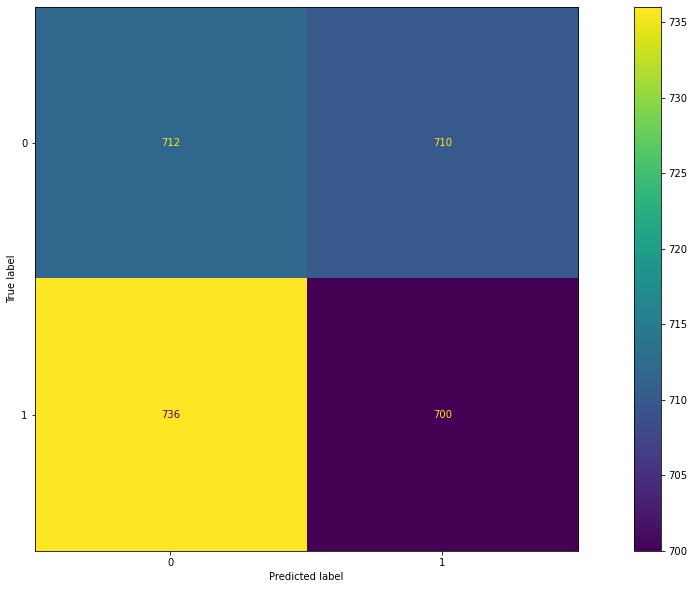

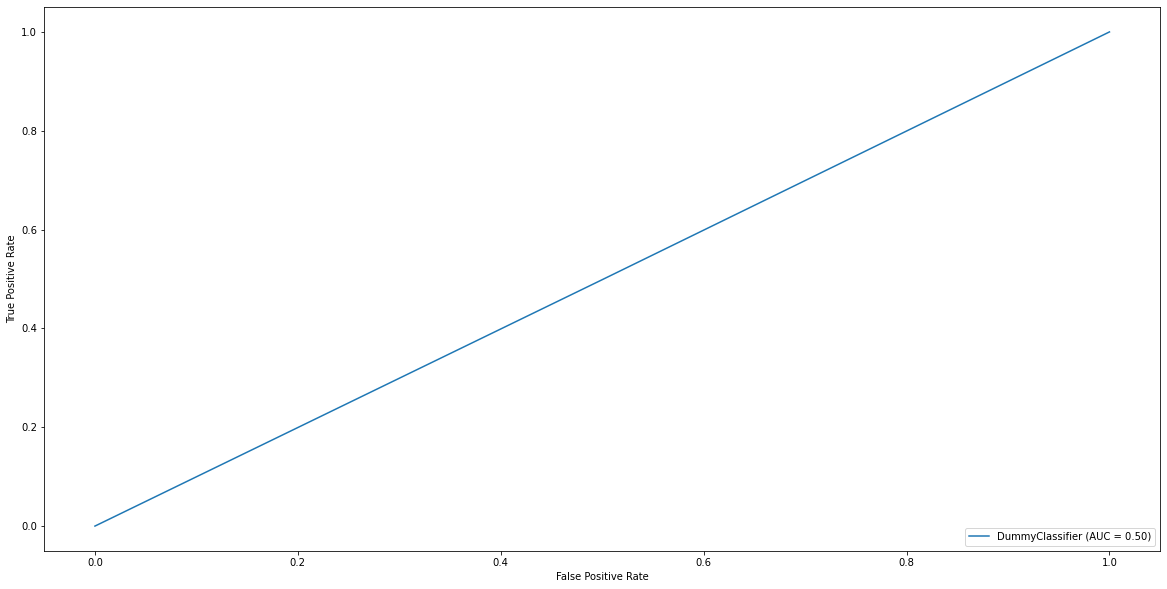

In [285]:
# Creating a new train/test split based on the features isolated from stepwise selection and VIF exploration
new_X = stepwise_X.drop(columns = ['ratio_intHyperlinks', 'length_words_raw', 'nb_dots', 'nb_slash', 'nb_colon', 'nb_subdomains'])
new_y = stepwise_y

X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, random_state = 42)
# Dummy Classifier as baseline model
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_train)
y_test_pred = dummy.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
dummy.score(X_test, y_test)
score_matrix_printer(dummy, X_train, y_train, X_test, y_test);

The baseline model produced a score of ~50% for both the accuracy and the recall, which is what we expected. I am choosing to focus on accuracy because the overall accuracy of the model is important in correctly identifying a phishing website. I am also choosing to focus on recall becasue the recall score helps correctly identify a false positive in the dataset. A false positive with respect to this project would essentially be "falling for the phishing tactic" -- meaning that the model incorrectly identified the data as a legitimate website when in reality it should be labeled as a phishing website.

## Model 1: Logistic Regression Model

In [286]:
# Simple Logistic Regression Model 
# Set max_iter hyperparameter = 1000 since there are so many initial features
# Will likely be dropping/aggregating columns since there are a few features with high correlation w/ each other.
lr = LogisticRegression(max_iter = 100000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


    Train Accuracy: 93.54%
    Train Precision: 93.55%
    Train Recall: 93.5%
    ------------------------------
    Test Accuracy: 93.98%
    Test Precision: 93.89%
    Test Recall: 94.15%
    


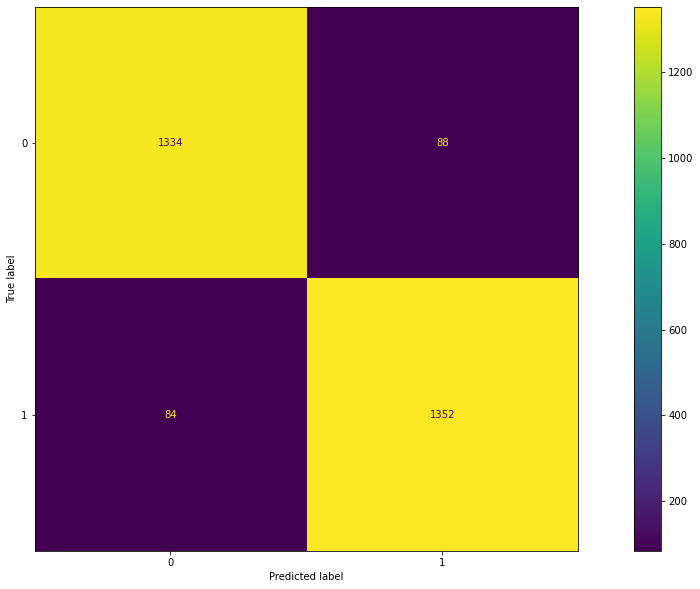

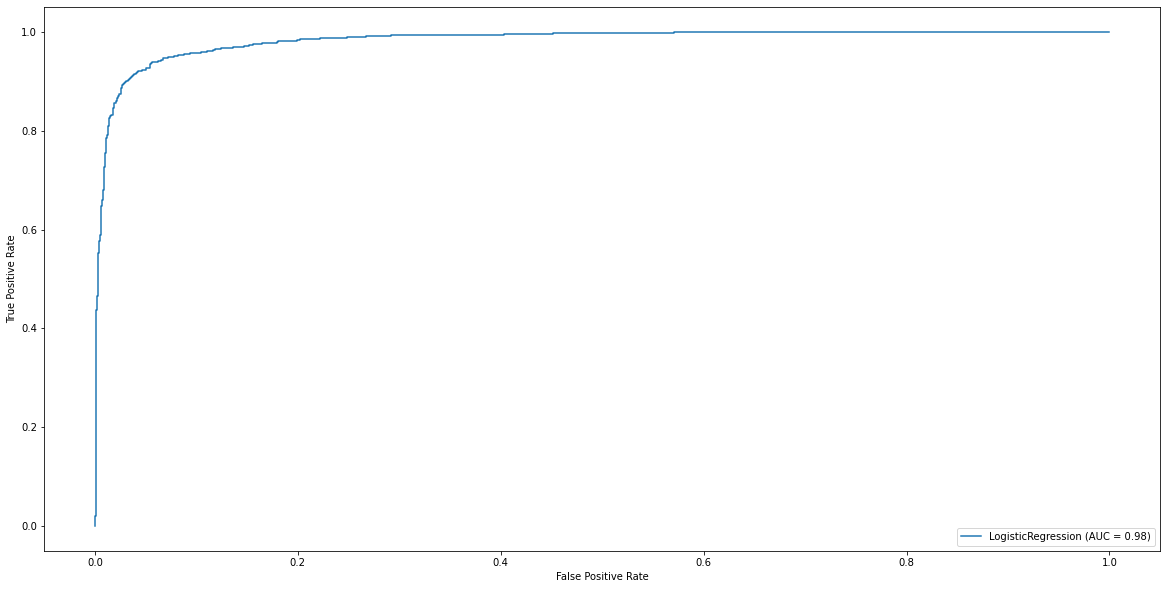

In [287]:
score_matrix_printer(lr, X_train, y_train, X_test, y_test)

In [288]:
# Since the coefficients are in log-odds, take the exponent to see the odds of each feature based on the initial logistic regression model
oddscoef = np.exp(lr.coef_)
# Put the column names and coefficients into a dataframe for ease of access
result = pd.concat([(pd.DataFrame(new_X.columns)), (pd.DataFrame(oddscoef).transpose())], axis = 1)
# Resetting column values to 0, 1
result.columns = range(result.columns.size)
# Sorting dataframe by the coefficient values
result.sort_values(by = 1, ascending = False, inplace=True)
# Selecting top 10 values of log coefficients
top_10_coefs = result.iloc[:10]
# Converting feature names to a list to run a model later based on these coefficient values
list_of_top_10_coefs = list(top_10_coefs[0])
top_10_coefs


,0,1
34,google_index,18.934808
17,phish_hints,4.921076
3,nb_qm,3.818450
21,ratio_extHyperlinks,3.735669
11,shortening_service,3.437516
1,ip,2.843089
28,domain_in_title,2.444356
9,ratio_digits_host,2.156122
33,dns_record,1.710949
19,suspecious_tld,1.664519


In our dataset, a 0 indicates that the `google_index` of a page is present. If the data has the lack of a `google_index`, that means that the website is 20x as likely to be a phishing website. Similarly, the data also has a `phish_hints` feature. `phish_hints` refers to characteristics of these websites such as urgent action items, poor grammer or misspelled words, offers that are too good to be true, etc. If the data has any characteristics of these `phish_hints`, it is 5x as likely to be a phishing website. `nb_qm` is the number of question marks that are present in a url. As the number of question marks increases by one, the url becomes 4x as likely to be a phishing website. 

## Creation of Pipelines

Implemented a linear regression pipeline that will be used throughout the rest of project.

In [289]:
# LogisticRegression Pipeline
lrpipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())
])

## Model 2: Pipeline Integration 


    Train Accuracy: 93.69%
    Train Precision: 93.81%
    Train Recall: 93.53%
    ------------------------------
    Test Accuracy: 94.47%
    Test Precision: 94.31%
    Test Recall: 94.71%
    


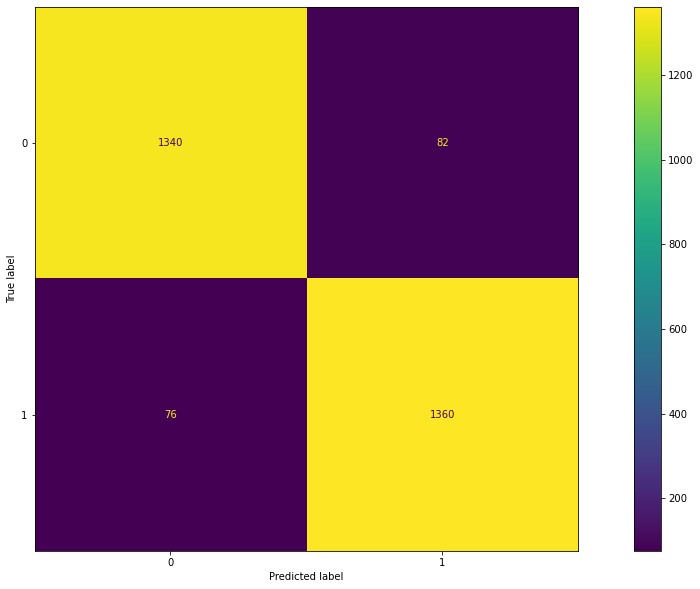

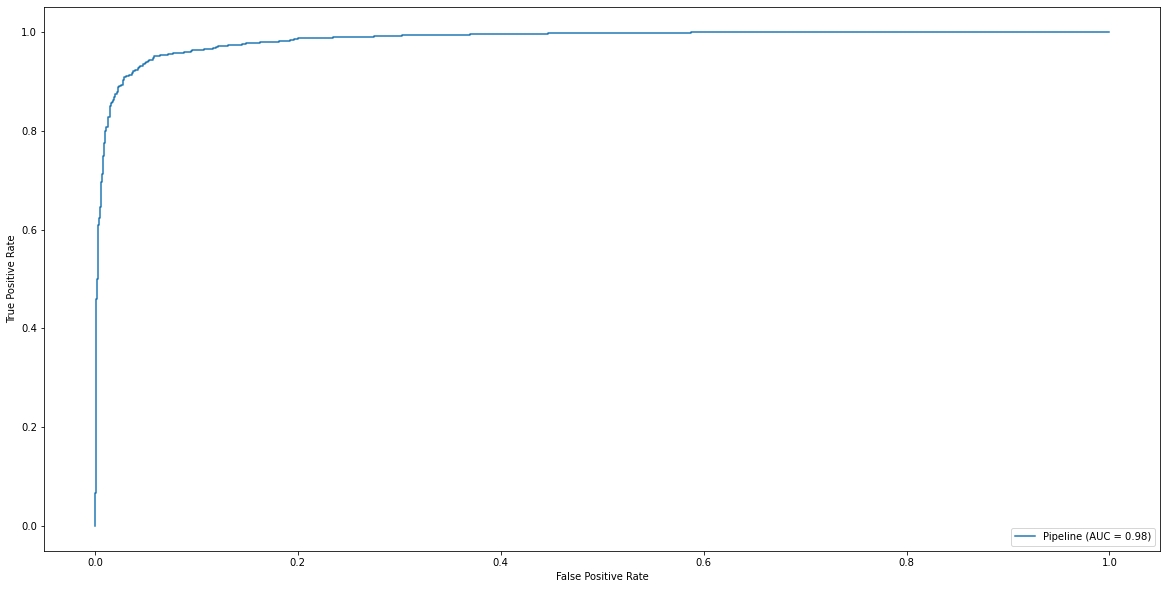

In [290]:
# LogisticRegression pipeline with StandardScalar step
lrpipe.fit(X_train, y_train)
lr_pipe_preds = lrpipe.predict(X_train)
score_matrix_printer(lrpipe, X_train, y_train, X_test, y_test)

The results of the logistic regression pipeline with the StandardScalar step produced a very similar model to that of the initial Logistic Regression model. Next I will attempt to reduce the number of features by selecting the important features through an ExtraTreeClassifier.

## Running GridSearchCV to Find Optimal Hyperparameters

Next, I will be checking the optimal hyperparameters for the Logistic Regression model ussing a GridSearchCV.

In [291]:
# Commenting out this GridSearchCV because it took ~10 minutes to run
# param_grid = {
#     "lr__penalty":['l1', 'l2', 'elasticnet', 'none'],
#     "lr__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#     "lr__max_iter":[1000, 10000, 50000, 100000]
# }

# grid = GridSearchCV(lrpipe, param_grid)
# grid.fit(X_train, y_train)  

In [292]:
# print(grid.best_params_)
# print(grid.best_score_)

In [293]:
# Reinstantiating pipeline for LogisticRegression with new optimized hyperparameters from GridSearchCV
newlrpipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(max_iter = 100000, penalty = 'l1', solver = 'liblinear'))
])

## Model 3: Logistic Regression with top 10 coefficients

After identifying the top coefficients from the initial Logistic Regression model, I wanted to see if those identified features would be important in identifying a phishing website or not.


    Train Accuracy: 88.89%
    Train Precision: 87.47%
    Train Recall: 90.75%
    ------------------------------
    Test Accuracy: 89.33%
    Test Precision: 87.62%
    Test Recall: 91.71%
    


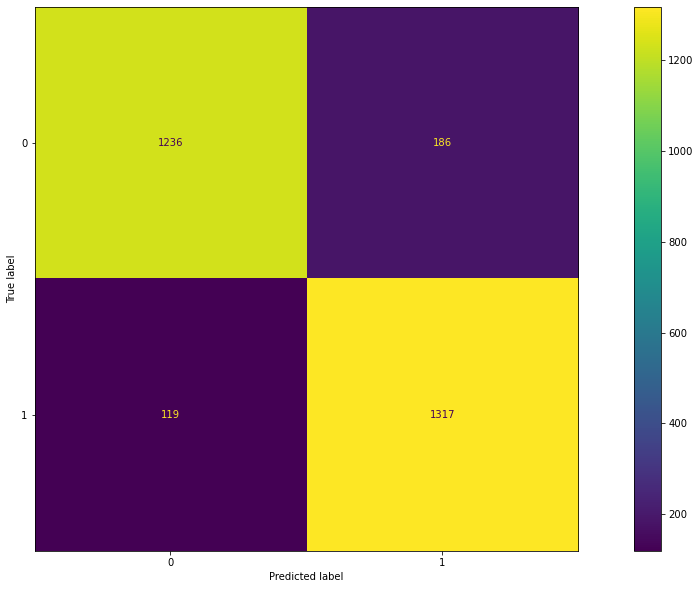

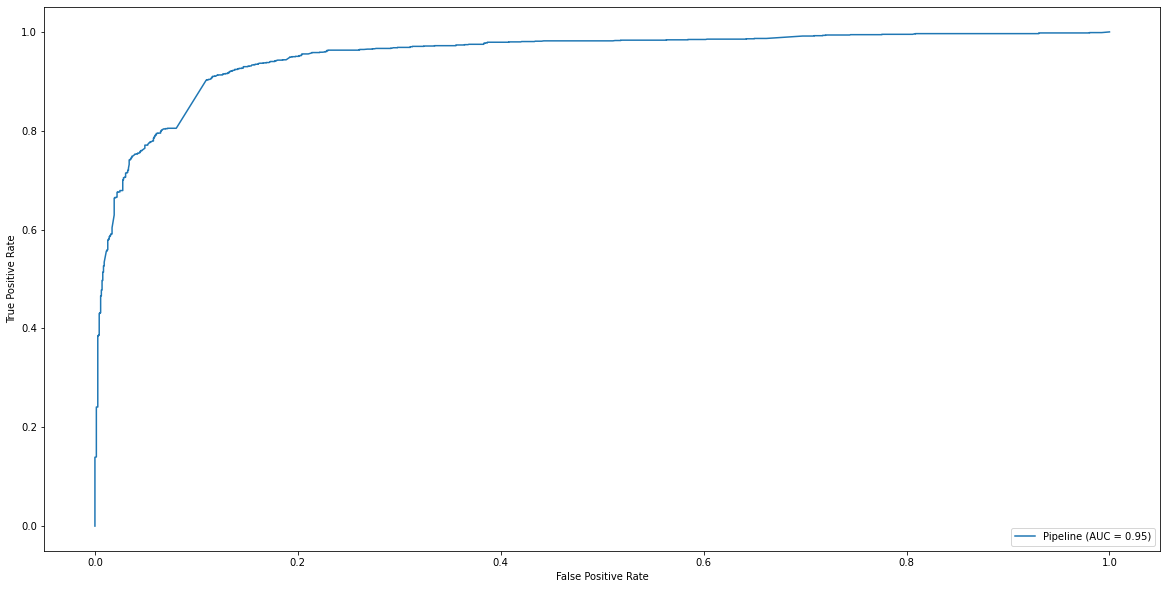

In [294]:
coefX = stepwise_X[list_of_top_10_coefs]

coefX_train, coefX_test, coefy_train, coefy_test = train_test_split(coefX, new_y, random_state = 42)

newlrpipe.fit(coefX_train, coefy_train)
lr_coef_preds = newlrpipe.predict(coefX_train)
score_matrix_printer(newlrpipe, coefX_train, coefy_train, coefX_test, coefy_test)


The results indicate that focusing on the features from the Logistic Regression model that had the highest coefficients values produced a overall lower accuracy and recall score. Although the score is high compared to the baseline model, there may be a few features that are more impotant in detecting a phishing website that the coefficients cannot indicate. Although the odds-ratio values do not produce the highest model score, they are still important in the interpretation of the models. Next I will utilize an ExtraTreeClassifier in order to identify the important features.

## Feature Importance (ExtraTreeClassifier)

Next an ExtraTreeClassifier model is ran in order to identify the 10 most important features in the dataset from the remainding 42.  Since the data is not normally distributed, I will utilize the ExtraTreeClassifiers because it deals with nonparametric data. The goal is to once again reduce the number of features in the model to then reduce the overall complexity of the model.

[1.85564767e-02 2.94458131e-02 2.94998793e-03 2.05107307e-02
 6.95707776e-03 4.01924209e-03 6.25130270e-02 8.20210930e-03
 1.66411237e-02 1.24132417e-02 8.02078888e-04 9.56757214e-03
 1.15537386e-02 3.12110218e-05 1.32264171e-02 1.51038900e-02
 1.29276241e-02 2.98641133e-02 8.94268234e-03 3.16327912e-03
 2.70197573e-02 2.91399561e-02 1.37615387e-02 9.40485290e-03
 1.44317580e-02 1.43335356e-02 3.26434895e-02 1.28944608e-02
 4.66605134e-02 1.94906242e-02 3.84849653e-03 1.53635907e-02
 3.58013097e-02 2.75207464e-03 3.12749969e-01 1.22312637e-01]


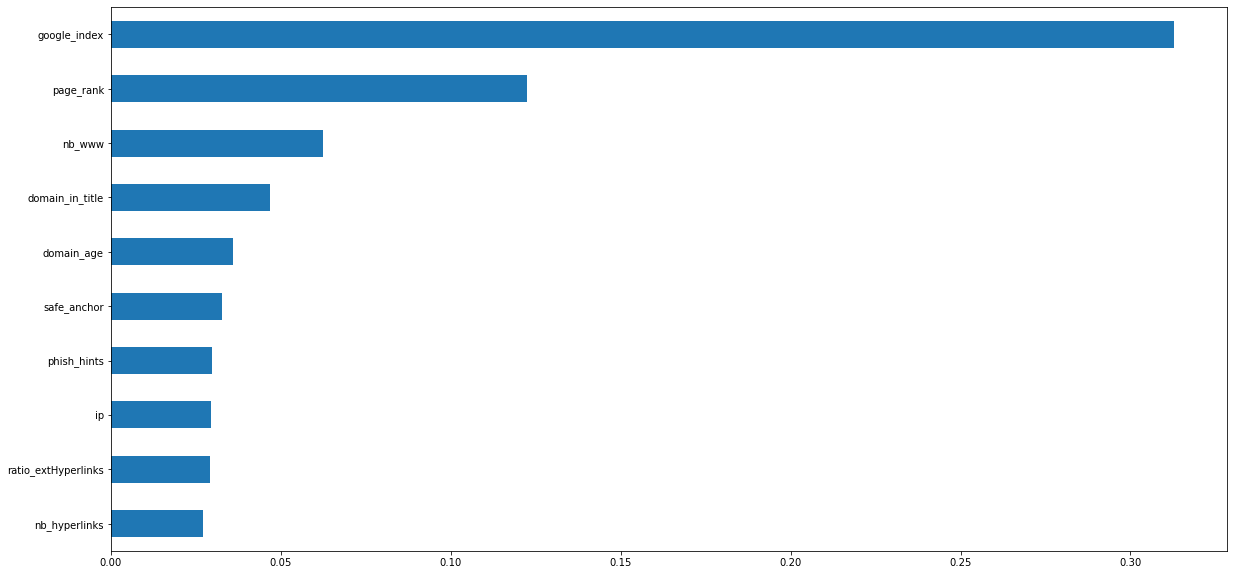

In [295]:
# Instantiate model
modelfeatures = ExtraTreesClassifier()
modelfeatures.fit(new_X, new_y)
print(modelfeatures.feature_importances_) # use built in class 'feature_importances' of tree based classifiers
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(modelfeatures.feature_importances_, index=new_X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

In [296]:
# Created a list of top features from ExtraTreeClassifier 
list_extraTree_features = ['domain_age', 'google_index', 'page_rank', 'domain_in_title', 'ip', \
    'ratio_intHyperlinks', 'ratio_extHyperlinks', 'nb_www', 'safe_anchor', 'phish_hints']

# Created a dataframe with the features identified from ExtraTreeClassifier
extraTreeX = X[list_extraTree_features]
extraTreeX

# Train/test split for top features from ExtraTreeClassifier
X1_train, X1_test, y1_train, y1_test = train_test_split(extraTreeX, new_y, random_state = 42)

This feature importance graph shows most important non-parametric features that may be important for detecting a phishing website. A list with these features and will be used as the focused features in the next model.

## Model 4: Pipeline with ExtraTree features 

Using the features that I identified from the code above, another LogisticRegression model is ran that solely focuses on the features that were identified in the ExtraTreeClassifier that are stored in the `list_extraTree_features` variable.


    Train Accuracy: 92.09%
    Train Precision: 91.96%
    Train Recall: 92.22%
    ------------------------------
    Test Accuracy: 92.37%
    Test Precision: 91.66%
    Test Recall: 93.31%
    


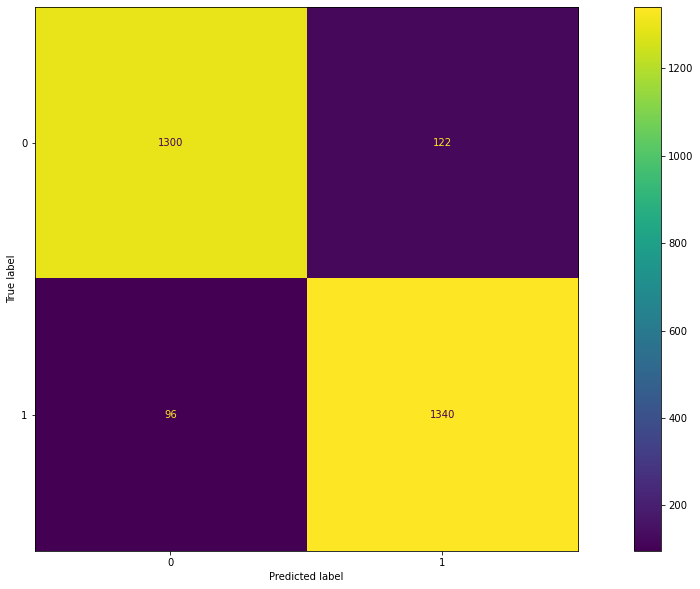

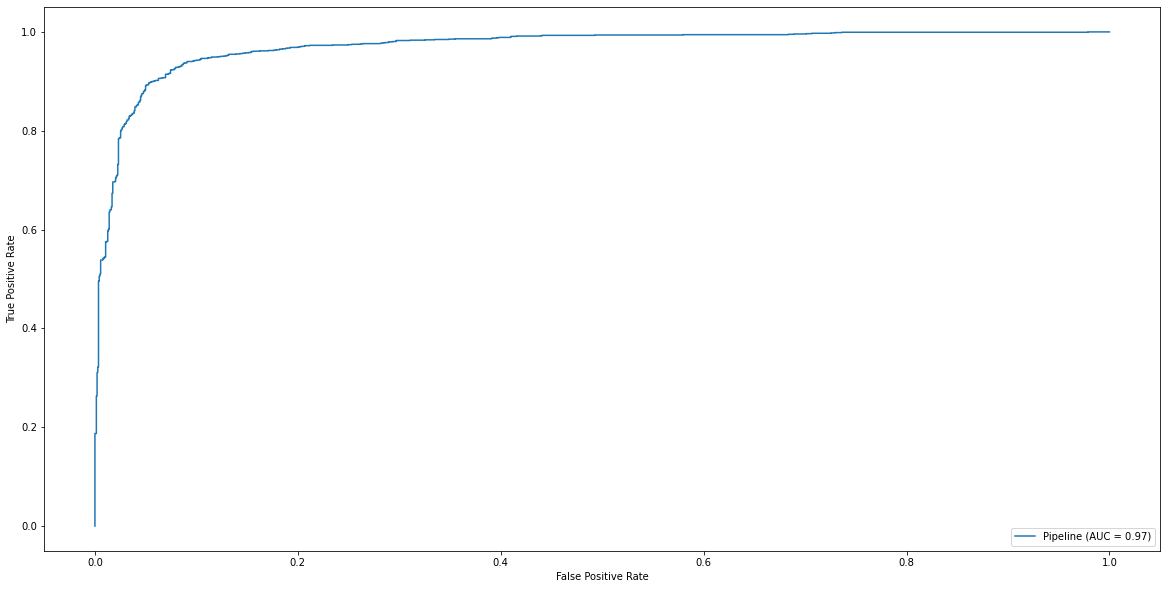

In [297]:
# Pipeline w/ StandardScalar and LogisticRegression steps w/ features selected from the ExtraTreeClassifier
newlrpipe.fit(X1_train, y1_train)
lr_pipe_preds = newlrpipe.predict(X1_train)
score_matrix_printer(newlrpipe, X1_train, y1_train, X1_test, y1_test)

After running a pipeline model based on the top 10 features that the ExtraTreeClassifier identified. This model that focused on the features stored in the `list_extraTree_features` variable produced an accuracy score of 92% and a recall score of 93% as well as having a AUC score of 0.97. <br>
Although the overall accuracy and recall score dropped by about 2%, this is a tradeoff that I am willing to accept because we reduced the number of features in this dataset to 10 features from the stepwise selection of 42. <br>
The reduction of 32 features strongly reduces the complexity of the model and is preferred over the overly complex model.    

# Evaluation

The model that performed best was the model that utilized the features identified through the ExtraTreeClassifier and the optimized hyperparamters of the GridSearchCV. This model produced an accuracy score of **92%** and a recall score of **93%**. <br>
The model also produces an AUC score of **0.97**, meaning that it has high classification accuracy. <br>


    Train Accuracy: 92.09%
    Train Precision: 91.96%
    Train Recall: 92.22%
    ------------------------------
    Test Accuracy: 92.37%
    Test Precision: 91.66%
    Test Recall: 93.31%
    


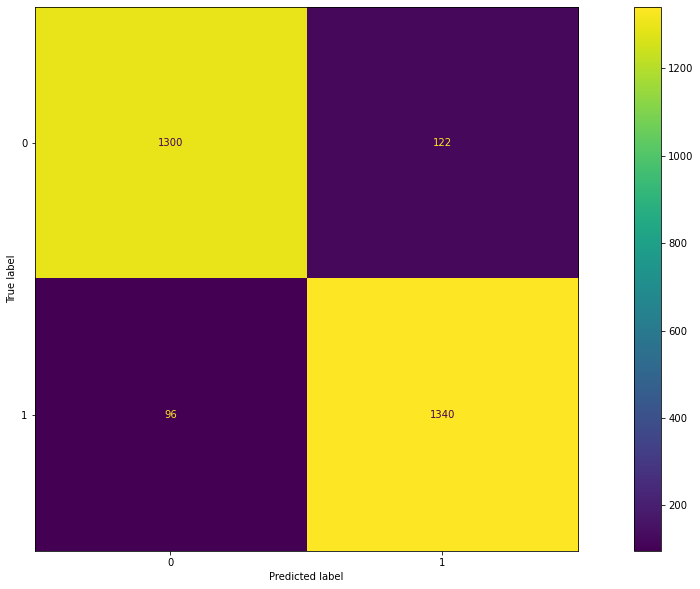

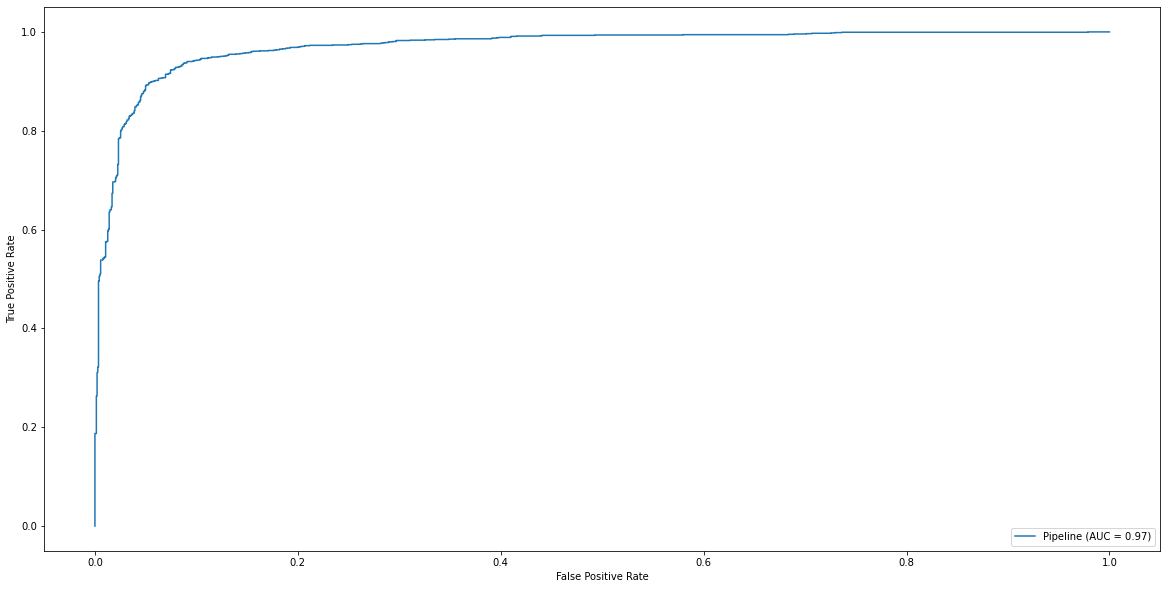

In [304]:
# Printing out training and test scores as well as the confusion matrix and AUC curve
score_matrix_printer(newlrpipe, X1_train, y1_train, X1_test, y1_test)

Overall, this final model performs exceptionally well on the data. I would recommend using this model and its features to assist in identifying phishing websites. 

# Conclusion

Overall, this final model has high potential in helping the AGSW in identifying phishing websites. This model can be used in tandem with the research that AGSW conducts to better identify phishing websites and protect those who would be susceptible to these kinds of cyber attacks. <br>
I identified some important features such as the `google_index` and the `phish_hints`. If a feature lacks a `google_index`(1), then the website is 20x more likely to be a phishing website. Similarly, if a website has `phish_hints` features, it is ~5x as likely to be a phishing website. 
Some future actions I would like to consider is:
- Utilize this model as a basis for tackling scam and phishing attacks that utilize text messages and phone calls instead of the traditional website.
- Implement this model in a website or application where people can input URLS and get an output of how likely a website is to be phishing or not.
- Utilize this model as a basis for phishing detection for other languages and nuances that may be country-specific.

# Appendix 

## PCA


PCA was initially conducted to address the large amount of features; however, the first principal component accounted for ~99% of the variance in the data. The results were inconclusive.

In [303]:
'''# Initial PCA
pca = PCA(n_components=5)
pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)
print(pca.components_)'''

'# Initial PCA\npca = PCA(n_components=5)\npca.fit_transform(X_train)\nprint(pca.explained_variance_ratio_)\nprint(pca.components_)'

## Random Forest Classifier

In [298]:
'''rfcpipe = Pipeline(steps=[
    ('rfc', RandomForestClassifier(max_depth = 5, random_state = 42))
])'''

In [299]:
'''rfc = RandomForestClassifier(max_features=5, random_state=42)
rfc.fit(new_X, new_y)'''

RandomForestClassifier(max_features=5, random_state=42)

In [300]:
'''model_estimators = rfc.estimators_'''

In [301]:
'''rfc.feature_importances_'''

array([2.92519283e-02, 1.04484295e-02, 1.40610203e-03, 8.64410129e-03,
       7.78255722e-03, 3.40514120e-03, 4.68152645e-02, 4.15475947e-03,
       2.95317241e-02, 1.64973926e-02, 4.96161708e-04, 6.46455916e-03,
       7.03036315e-03, 3.48616225e-05, 1.63909671e-02, 3.94109956e-02,
       2.36195388e-02, 3.32355147e-02, 4.10134597e-03, 1.74523671e-03,
       1.07089008e-01, 4.67317324e-02, 3.15137460e-02, 3.71111071e-03,
       9.28235424e-03, 8.29561377e-03, 3.32247210e-02, 4.60318963e-03,
       1.34095828e-02, 9.57435895e-03, 1.73823675e-03, 2.34662014e-02,
       4.53663618e-02, 1.39615226e-03, 2.20767546e-01, 1.49363140e-01])

In [302]:
'''feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, rfc.feature_importances_)}
feat_import'''

{'length_hostname': 0.029251928250129584,
 'ip': 0.010448429485869463,
 'nb_at': 0.0014061020281377376,
 'nb_qm': 0.008644101289277721,
 'nb_eq': 0.007782557217398895,
 'nb_percent': 0.0034051411959329534,
 'nb_www': 0.046815264510478766,
 'https_token': 0.004154759473128256,
 'ratio_digits_url': 0.029531724054670572,
 'ratio_digits_host': 0.016497392631272065,
 'port': 0.0004961617078880303,
 'shortening_service': 0.006464559162601083,
 'nb_redirection': 0.007030363152586551,
 'nb_external_redirection': 3.486162254237546e-05,
 'shortest_word_path': 0.016390967101276296,
 'longest_word_path': 0.0394109956433704,
 'avg_word_path': 0.02361953878964972,
 'phish_hints': 0.03323551470736125,
 'domain_in_brand': 0.004101345969984292,
 'suspecious_tld': 0.001745236713958374,
 'nb_hyperlinks': 0.10708900810303787,
 'ratio_extHyperlinks': 0.046731732429927654,
 'ratio_extRedirection': 0.03151374603402686,
 'external_favicon': 0.00371111071246002,
 'ratio_intMedia': 0.009282354240692183,
 'ratio